In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# new import statements
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

import numpy as np

# Regression 2

In [2]:
# Do not reptitivitely download large datasets
# Save a local copy instead
dataset_file = "covid.geojson"
if os.path.exists(dataset_file):
    print("Reading local file.")
    df = gpd.read_file(dataset_file)
else:
    print("Downloading the dataset.")
    url = "https://dhsgis.wi.gov/server/rest/services/DHS_COVID19/COVID19_WI_V2/MapServer/9/query?outFields=*&where=1%3D1&f=geojson"
    df = gpd.read_file(url)
    df.to_file(dataset_file)

### Predicting "DTH_CUM_CP"

In [3]:
df = df.replace(-999, 2)
# Removing outlier point
df = df[df["GEOID"].str.fullmatch(r"\d+")]

#### Did our model learn, or just memorize (that is, "overfit")?

- Split data into train and test

#### `train_test_split(<dataframe>, test_size=<val>)`

- requires `from sklearn.model_selection import train_test_split`
- shuffles the data and then splits based on 75%-25% split between train and test
    - produces new train and test data every single time
- `test_size` parameter can take two kind of values:
    - actual number of rows that we want in test data
    - fractional number representing the ratio of train versus test data
    - default value is `0.25`
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [4]:
xcols = ["POP"]
ycol = "DTH_CUM_CP"

In [5]:
train, test = train_test_split(df)

# Let's use the train and the test data
model = LinearRegression()
# Fit using training data
model.fit(train[xcols], train[ycol])
# Predict using test data
y = model.predict(test[xcols])
# We can use score directly as it automatically invokes predict
model.score(test[xcols], test[ycol])

0.23185112007711017

Running the above cell again will give you entirely different model and score.

#### How can we minimize noise due to random train/test splits?

### Cross validation: `cross_val_score(estimator, X, y)`

- requires `from sklearn.model_selection import cross_val_score`
-  do many different train/test splits of the values, fitting and scoring the model across each combination
- cross validation documentation: https://scikit-learn.org/stable/modules/cross_validation.html
- function documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [6]:
train, test = train_test_split(df)

model = LinearRegression()
scores = cross_val_score(model, train[xcols], train[ycol])
scores

array([0.23361711, 0.24630389, 0.19315563, 0.18250837, 0.162016  ])

In [7]:
# Compute mean of the scores
scores.mean()

0.2035202001053924

#### How can we compare models?
- model 1: POP => DEATHS
- model 2: CASES (POS_CUM_CP) => DEATHS

In [8]:
model1 = LinearRegression()
model2 = LinearRegression()
model1_scores = cross_val_score(model1, train[["POP"]], train[ycol])
model2_scores = cross_val_score(model2, train[["POS_CUM_CP"]], train[ycol])

In [9]:
model1_scores.mean()

0.2035202001053924

In [10]:
model2_scores.mean()

0.25269939601064634

Which of these two models do you think will perform better? Probably model2.

<AxesSubplot:>

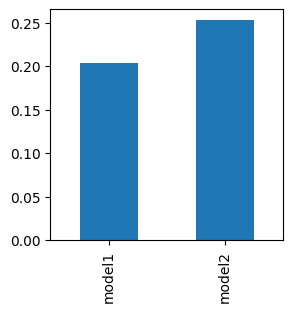

In [11]:
means = pd.Series({"model1": model1_scores.mean(),
                   "model2": model2_scores.mean()})
means.plot.bar(figsize=(3, 3))

How do we know the above difference is not noise? Let's calculate standard deviation and display error bars on the bar plot.

In [12]:
model1_scores.std()

0.0316473938485336

In [13]:
model2_scores.std()

0.03884725799501852

In [14]:
err = pd.Series({"model1": model1_scores.std(),
                 "model2": model2_scores.std()})
err

model1    0.031647
model2    0.038847
dtype: float64

<AxesSubplot:>

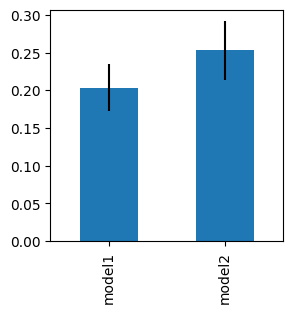

In [15]:
# Plot error bar by passing argument to paramenter yerr
means.plot.bar(figsize=(3, 3), yerr=err)

Pick a winner and run it one more time against test data.

#### How can we use multiple x variables (multiple regression)?

- Features: Positive cases per age range

In [16]:
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'TESTS_POS_CONF',
       'TESTS_POS_CONF_NEW', 'TESTS_POS_CONF_7DAYAVG', 'PercentNAATPos',
       'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG', 'POS_CUM_CONF',
       'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB', 'POS_NEW_PROB',
       'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF', 'DTH_7DAYAVG_CONF',
       'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB', 'DTH_7DAYAVG_PROB',
       'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP', 'POS_OTH_CP',
       'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP', 'DTHS_MALE_CP',
       'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP', 'DTHS_20_29_CP',
       'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP', 'DTHS_60_69_CP',
       'DTH

In [17]:
xcols = ['POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP']
ycol = "DTH_CUM_CP"

model = LinearRegression()
model.fit(train[xcols], train[ycol])
model.score(test[xcols], test[ycol]) 

0.5969237112181877

#### How can we interpret what features the model is relying on?

In [18]:
model.coef_

array([-0.03095195, -0.00168434,  0.00070067,  0.00813045,  0.01200583,
        0.00106643,  0.02584217, -0.02147325,  0.12294742,  0.17998956])

In [19]:
pd.Series(model.coef_)

0   -0.030952
1   -0.001684
2    0.000701
3    0.008130
4    0.012006
5    0.001066
6    0.025842
7   -0.021473
8    0.122947
9    0.179990
dtype: float64

<AxesSubplot:>

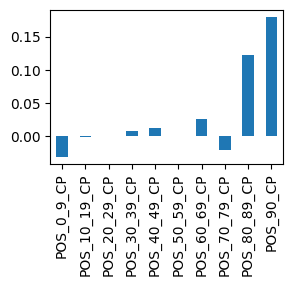

In [20]:
pd.Series(model.coef_, index=xcols).plot.bar(figsize=(3, 2))

<div>
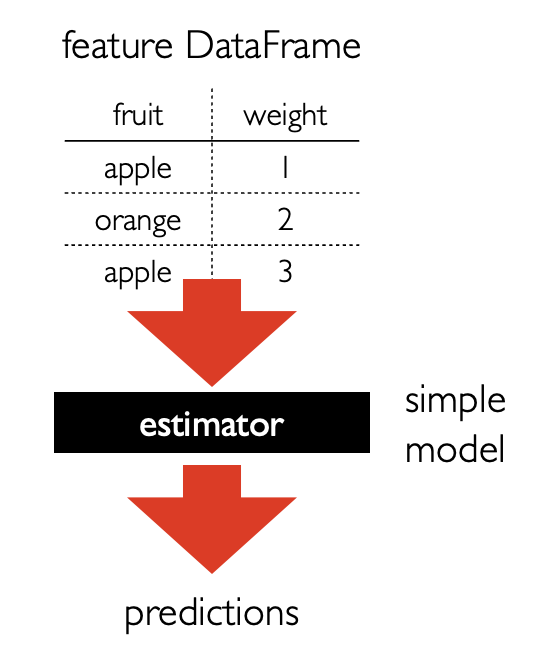
</div>

### Lake Michigan Waves

Source: https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

In [21]:
df = pd.read_csv("waves.csv")
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Calumet Beach,04/07/2018 12:30:00 AM,21.7,3.15,NaN,0.389,3.0,0.0,04/07/2018 12:30 AM,CalumetBeach201804072430
1,Ohio Street Beach,06/14/2019 07:00:00 PM,16.0,2.18,NaN,0.137,3.0,11.8,06/14/2019 7:00 PM,OhioStreetBeach201906141900
2,Ohio Street Beach,05/16/2018 01:00:00 PM,21.7,1.92,NaN,0.023,1.0,10.3,05/16/2018 1:00 PM,OhioStreetBeach201805161300
3,Ohio Street Beach,05/16/2018 02:00:00 PM,21.9,1.81,NaN,0.026,6.0,10.3,05/16/2018 2:00 PM,OhioStreetBeach201805161400
4,Ohio Street Beach,06/04/2018 09:00:00 AM,23.0,0.03,NaN,0.021,8.0,12.4,06/04/2018 9:00 AM,OhioStreetBeach201806040900


In [22]:
df.columns

Index(['Beach Name', 'Measurement Timestamp', 'Water Temperature', 'Turbidity',
       'Transducer Depth', 'Wave Height', 'Wave Period', 'Battery Life',
       'Measurement Timestamp Label', 'Measurement ID'],
      dtype='object')

#### Can we predict wave height based on wave period (time between waves)?

<AxesSubplot:xlabel='Wave Period', ylabel='Wave Height'>

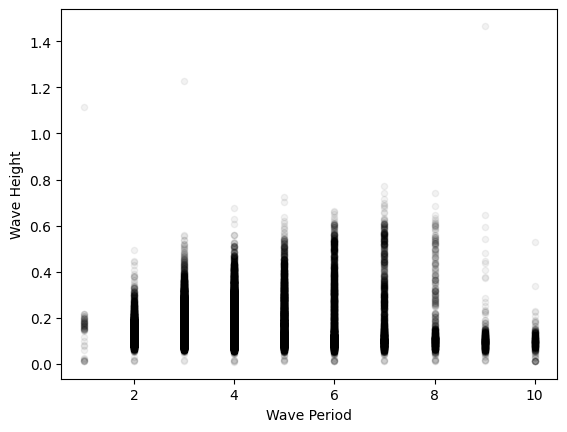

In [23]:
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.05)

Observation: non-linear relationship => fitting straight line will not work.

#### Can we predict wave height based on beach name and wave period?

In [24]:
beach_names = sorted(set(df["Beach Name"]))
beach_names

['63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

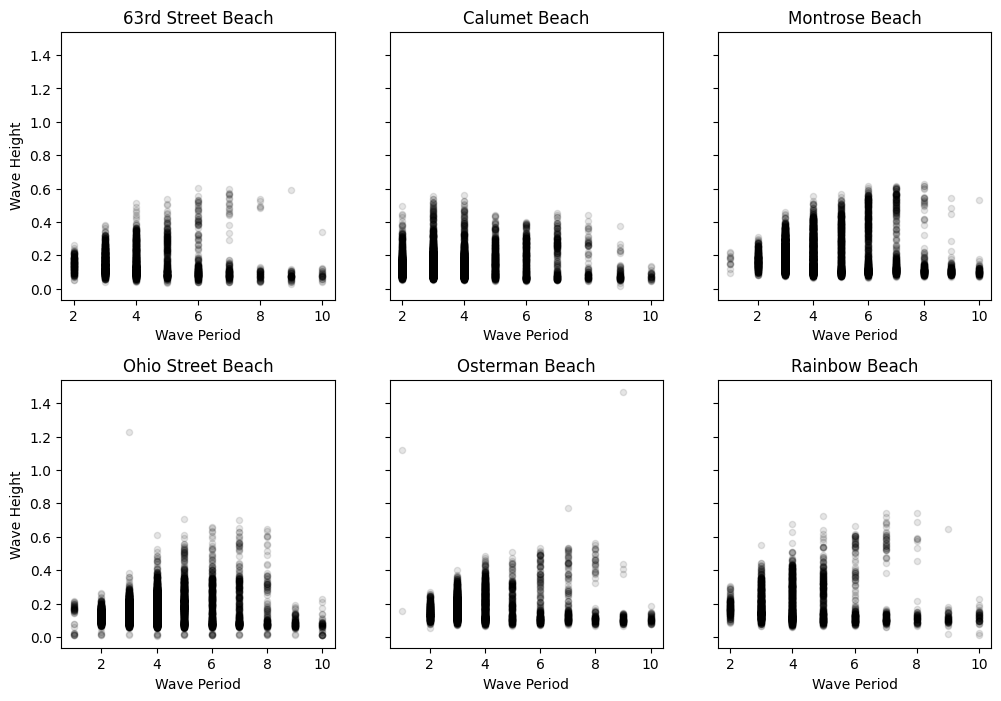

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.3)
axes = list(axes.reshape(-1))
for b in beach_names:
    ax = axes.pop(0)
    ax.set_title(b)
    beach_df = df[df["Beach Name"] == b]
    beach_df.plot.scatter(x="Wave Period", y="Wave Height", 
                          color="k", alpha=0.1, ax=ax)


Obversation: which beach (categorical feature) is important.

### Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

`train_test_split(<dataframe>, random_state=<some number>)`
- `random_state` enables us to control the randomization
- when we pass the same number, we will get the same training and test data (psuedo randomization)

In [26]:
train, test = train_test_split(df, random_state=320)
train.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
28817,Ohio Street Beach,07/04/2019 04:00:00 PM,21.5,0.94,NaN,0.137,4.0,11.8,07/04/2019 4:00 PM,OhioStreetBeach201907041600
13162,Calumet Beach,08/07/2016 04:00:00 PM,25.5,0.67,NaN,0.253,2.0,9.8,08/07/2016 4:00 PM,CalumetBeach201608071600
13110,Calumet Beach,08/05/2016 11:00:00 AM,24.1,1.03,NaN,0.173,3.0,10.1,08/05/2016 11:00 AM,CalumetBeach201608051100
23538,Ohio Street Beach,06/15/2015 08:00:00 AM,18.0,1.25,NaN,0.066,4.0,11.9,06/15/2015 8:00 AM,OhioStreetBeach201506150800
30642,Ohio Street Beach,07/29/2017 07:00:00 PM,23.4,3.80,NaN,0.187,3.0,11.5,07/29/2017 7:00 PM,OhioStreetBeach201707291900


#### Model 1: Wave Period (Linear)

`cross_val_score(estimator, X, y, cv=<number>)`
- `cv` enables us mention how many folds we want for the cross-validation

In [27]:
xcols = ["Wave Period"]
ycol = "Wave Height"

m1 = LinearRegression()
scores = cross_val_score(m1, train[xcols], train[ycol], cv=10)
scores

array([0.00454365, 0.00482049, 0.00061895, 0.00133868, 0.0021266 ,
       0.0045598 , 0.00501976, 0.00087213, 0.00324963, 0.00139934])

In [28]:
scores.mean()

0.0028549034281171947

We want the mean score to be large.

In [29]:
scores.std()

0.0016835509327158373

We want the standard deviation to be small, to make sure that our model isn't too sensitive to changes in training and test data.

#### Model 2: Wave Period (Polynomial)

LinearRegression can do this:

```
y = 3*x1 + 5*x2
```
It CANNOT do this:
```
y = 3*x + 5*x^2
```
TRICK:
```
x1 = x
x2 = x^2
```

<div>
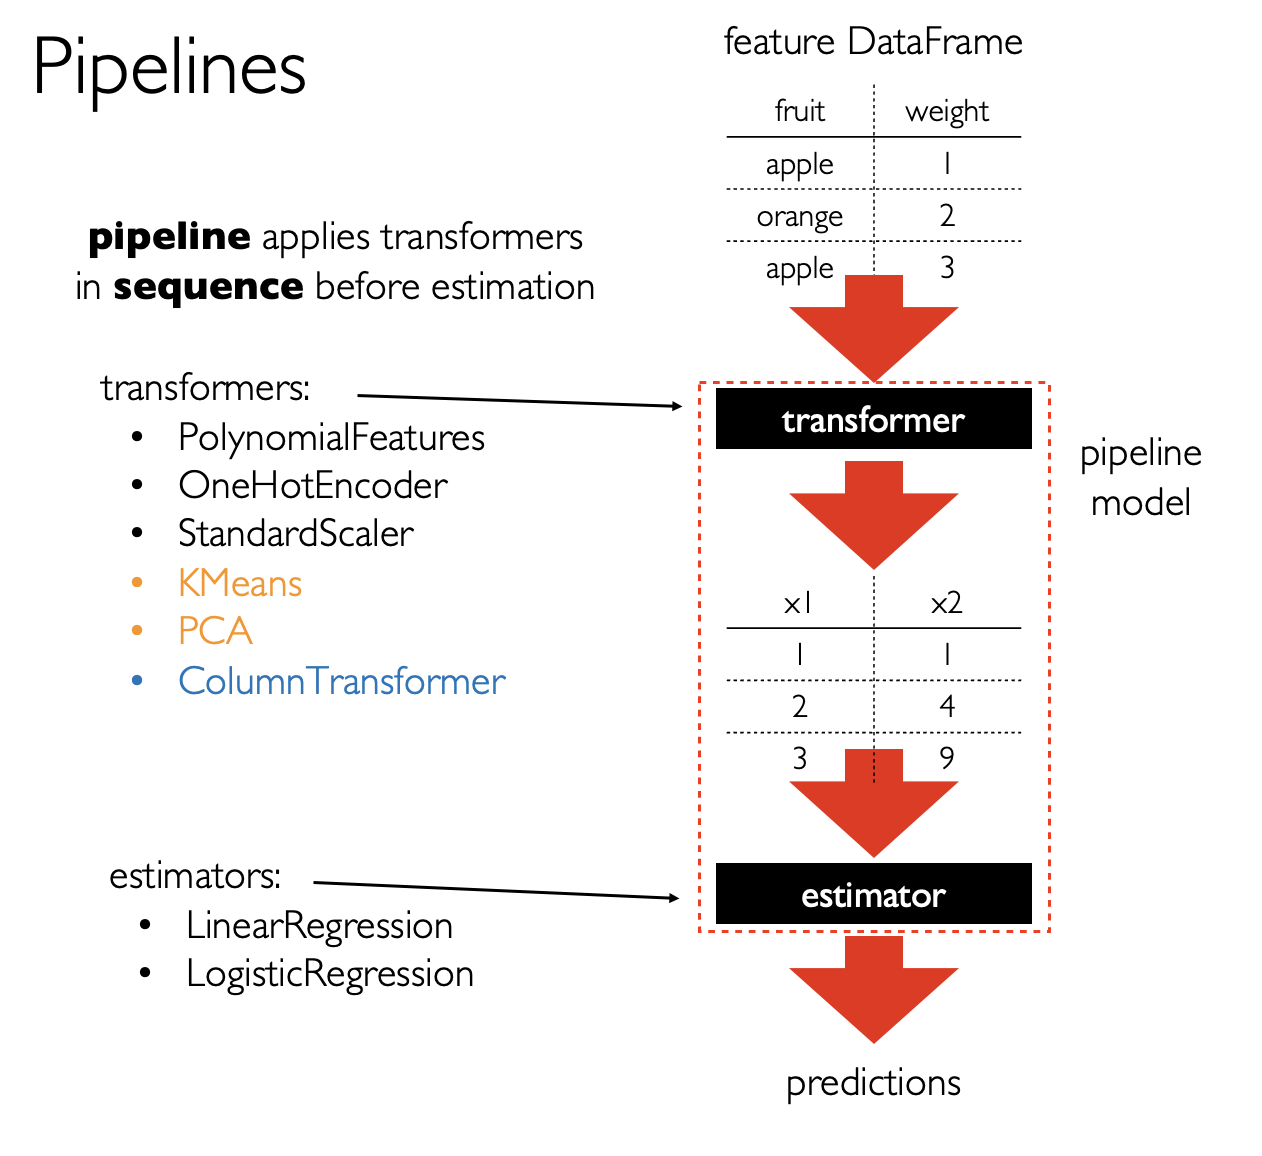
</div>

In [30]:
# Let's make a copy before we add new columns
# Recommendation: don't change the data referred to by a specific variable 
# throughout your code

train2 = train[xcols].copy()
train2.head()

,Wave Period
28817,4.0
13162,2.0
13110,3.0
23538,4.0
30642,3.0


Manually adding columns for x^2, x^3, etc.,

In [31]:
train2["Wave Period ^ 2"] = train2["Wave Period"] ** 2
train2["Wave Period ^ 3"] = train2["Wave Period"] ** 3
train2["sqrt(Wave Period"] = train2["Wave Period"] ** 0.5
train2.head()

,Wave Period,Wave Period ^ 2,Wave Period ^ 3,sqrt(Wave Period
28817,4.0,16.0,64.0,2.000000
13162,2.0,4.0,8.0,1.414214
13110,3.0,9.0,27.0,1.732051
23538,4.0,16.0,64.0,2.000000
30642,3.0,9.0,27.0,1.732051


#### `PolynomialFeatures(degree=<val>, include_bias=False)`

- `degree` enables us to mention how many degrees we need
- `include_bias` default value is True, which will add a column of 1s - we typically don't use that.
- returns an object instance on which we can invoke `fit` and `transform`:
    - `transform(X, columns=<col names>)`: transform data to polynomial features`
    - `fit_transform(X[, y])`: fit to data, then transform it.
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [32]:
pf = PolynomialFeatures(degree=4, include_bias=False)

In [33]:
# Fit the data
pf.fit(train[xcols])

PolynomialFeatures(degree=4, include_bias=False)

In [34]:
# Transform the data
pf.transform(train[xcols])

array([[4.000e+00, 1.600e+01, 6.400e+01, 2.560e+02],
       [2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01],
       [3.000e+00, 9.000e+00, 2.700e+01, 8.100e+01],
       ...,
       [4.000e+00, 1.600e+01, 6.400e+01, 2.560e+02],
       [4.000e+00, 1.600e+01, 6.400e+01, 2.560e+02],
       [7.000e+00, 4.900e+01, 3.430e+02, 2.401e+03]])

In [35]:
# Convert result of transformation into a DataFrame - step 1
pd.DataFrame(pf.transform(train[xcols]))

,0,1,2,3
0,4.0,16.0,64.0,256.0
1,2.0,4.0,8.0,16.0
2,3.0,9.0,27.0,81.0
3,4.0,16.0,64.0,256.0
4,3.0,9.0,27.0,81.0
...,...,...,...,...
29866,3.0,9.0,27.0,81.0
29867,5.0,25.0,125.0,625.0
29868,4.0,16.0,64.0,256.0
29869,4.0,16.0,64.0,256.0


How can we add meaningful column names? `pf.get_feature_names_out()`

In [36]:
pf.get_feature_names_out()

array(['Wave Period', 'Wave Period^2', 'Wave Period^3', 'Wave Period^4'],
      dtype=object)

In [37]:
# Convert result of transformation into a DataFrame - step 2
pd.DataFrame(pf.transform(train[xcols]), columns=pf.get_feature_names_out())

,Wave Period,Wave Period^2,Wave Period^3,Wave Period^4
0,4.0,16.0,64.0,256.0
1,2.0,4.0,8.0,16.0
2,3.0,9.0,27.0,81.0
3,4.0,16.0,64.0,256.0
4,3.0,9.0,27.0,81.0
...,...,...,...,...
29866,3.0,9.0,27.0,81.0
29867,5.0,25.0,125.0,625.0
29868,4.0,16.0,64.0,256.0
29869,4.0,16.0,64.0,256.0


In [38]:
# Putting all the steps together
pf = PolynomialFeatures(degree=4, include_bias=False)
pf.fit(train[xcols])
pd.DataFrame(pf.transform(train[xcols]), columns=pf.get_feature_names_out()).head()

,Wave Period,Wave Period^2,Wave Period^3,Wave Period^4
0,4.0,16.0,64.0,256.0
1,2.0,4.0,8.0,16.0
2,3.0,9.0,27.0,81.0
3,4.0,16.0,64.0,256.0
4,3.0,9.0,27.0,81.0


`fit_transform(X[, y])`: fit to data, then transform it.

In [39]:
new_data = pf.fit_transform(train[xcols])
pd.DataFrame(new_data, columns=pf.get_feature_names_out()).head()

,Wave Period,Wave Period^2,Wave Period^3,Wave Period^4
0,4.0,16.0,64.0,256.0
1,2.0,4.0,8.0,16.0
2,3.0,9.0,27.0,81.0
3,4.0,16.0,64.0,256.0
4,3.0,9.0,27.0,81.0


#### `Pipeline(...)`

- Argument: list of steps in the pipeline:
    - each step represented as a tuple with name of the step and the object instance
    - last step will be the estimator
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [40]:
m2 = Pipeline([
    ("pf", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])
m2

Pipeline(steps=[('pf', PolynomialFeatures(include_bias=False)),
                ('lr', LinearRegression())])

In [41]:
scores = cross_val_score(m2, train[xcols], train[ycol], cv=10)
scores.mean()

0.048992293142027354

**Conclusion:** mean R^2 score increased from 0.0029 (linear model) to 0.0489 (polynomial) - not bad!

#### Model 3: Beach Name (Categorical)

In [42]:
train["Beach Name"].unique()

array(['Ohio Street Beach', 'Calumet Beach', 'Rainbow Beach',
       'Osterman Beach', '63rd Street Beach', 'Montrose Beach'],
      dtype=object)

Naive way of assigning numerial values to a categorical column:
- `Ohio Street Beach`: 1
- `Calumet Beach`: 2
- `Rainbow Beach`: 3, etc.,
- Problem: `Calumet Beach` will become an average of `Ohio Street Beach` and `Rainbow Beach` => this doesn't make any sense!

#### `OneHotEncoder()`

- encodes categorical features as a one-hot numeric array
- returns a "sparse matrix", which needs to be explicitly converted into an `array` using `to_array()` method, before `DataFrame` conversion
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [43]:
xcols = ["Beach Name"]

In [44]:
oh = OneHotEncoder()
oh.fit_transform(train[xcols])

<29871x6 sparse matrix of type '<class 'numpy.float64'>'
	with 29871 stored elements in Compressed Sparse Row format>

In [45]:
oh.fit_transform(train[xcols])

<29871x6 sparse matrix of type '<class 'numpy.float64'>'
	with 29871 stored elements in Compressed Sparse Row format>

In [46]:
# All steps
oh = OneHotEncoder()
pd.DataFrame(oh.fit_transform(train[xcols]).toarray(), columns=oh.get_feature_names_out())

,Beach Name_63rd Street Beach,Beach Name_Calumet Beach,Beach Name_Montrose Beach,Beach Name_Ohio Street Beach,Beach Name_Osterman Beach,Beach Name_Rainbow Beach
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
29866,0.0,0.0,0.0,0.0,1.0,0.0
29867,0.0,0.0,0.0,1.0,0.0,0.0
29868,0.0,0.0,0.0,0.0,1.0,0.0
29869,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ("lr", LinearRegression())
])
m3

Pipeline(steps=[('oh', OneHotEncoder()), ('lr', LinearRegression())])

In [48]:
scores = cross_val_score(m3, train[xcols], train[ycol], cv=10)
scores.mean()

0.04564310407563701

**Conclusion:** mean R^2 score is slightly lower than 0.0489 (polynomial).

<div>
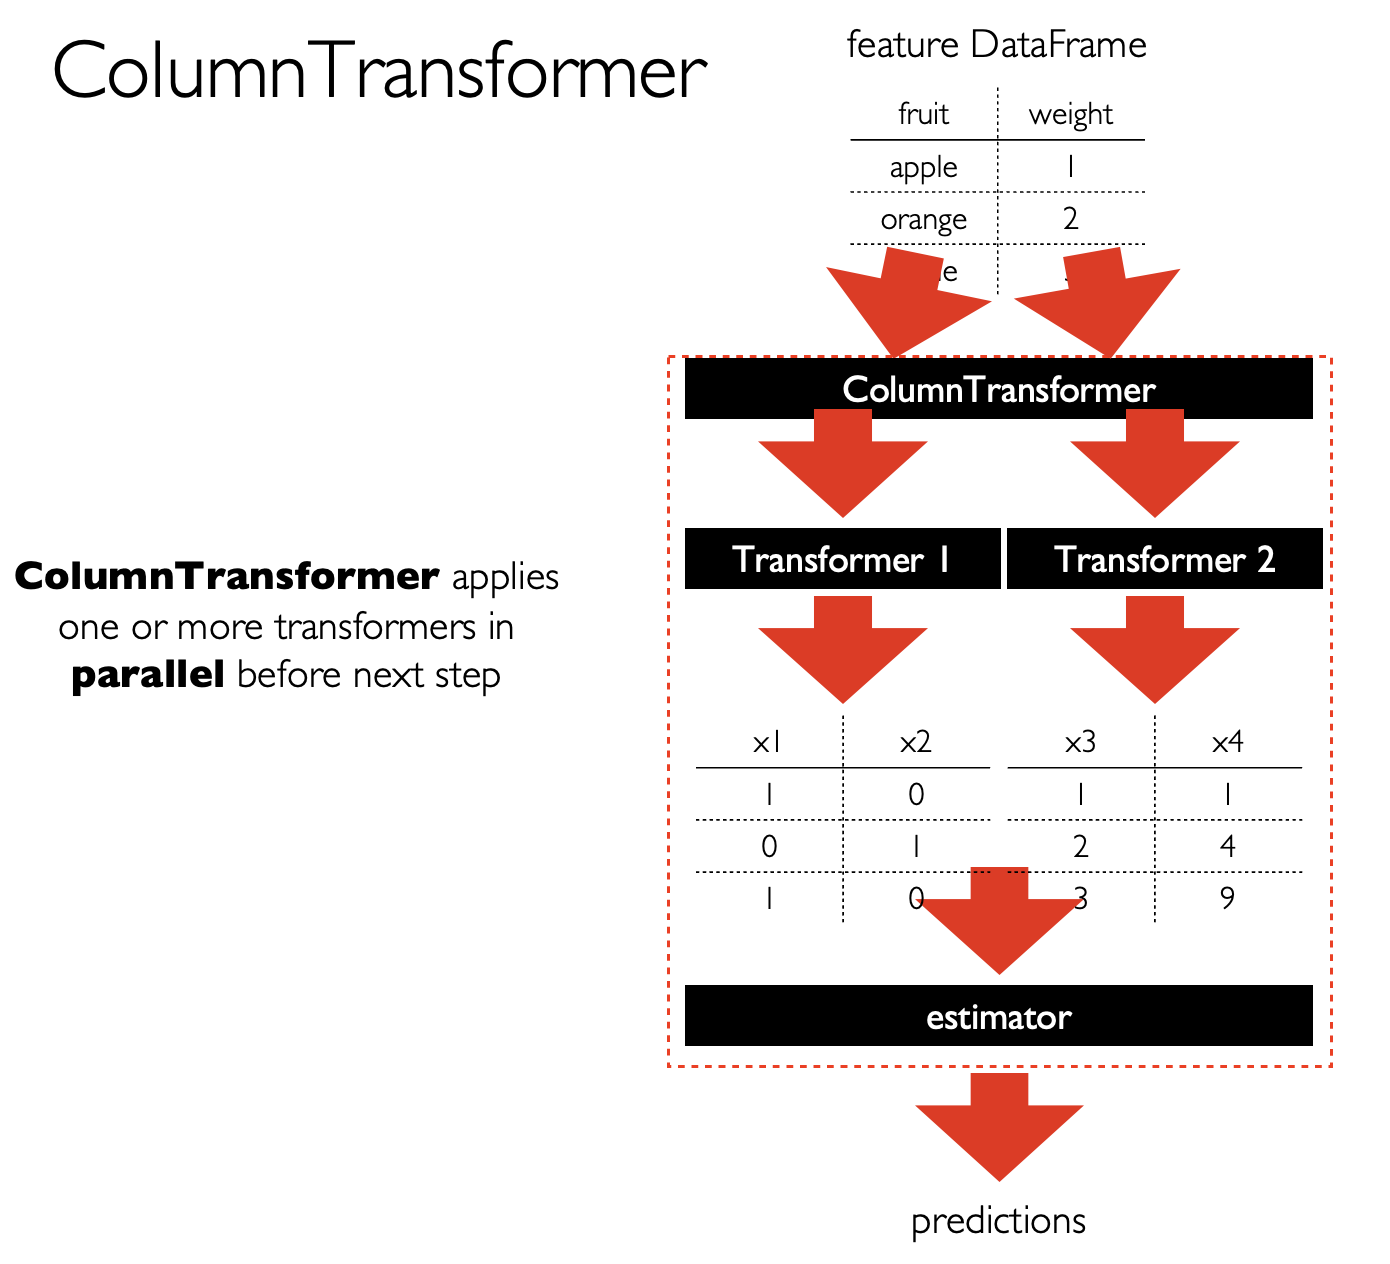
</div>

#### `make_column_transformer(...)`

- Argument: transformations
    - each transformer argument will be a `tuple` with object instance as first item and list of feature columns as the second
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html

#### Model 4: Beach Name (Categorical) and Wave Period (Polynomial)

In [49]:
custom_trans = make_column_transformer(
    (PolynomialFeatures(), ["Wave Period"]),
    (OneHotEncoder(), ["Beach Name"]),
)
custom_trans

ColumnTransformer(transformers=[('polynomialfeatures', PolynomialFeatures(),
                                 ['Wave Period']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Beach Name'])])

In [50]:
m4 = Pipeline([
    ("transformers", custom_trans),
    ("lr", LinearRegression()),
])
m4

Pipeline(steps=[('transformers',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  ['Wave Period']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Beach Name'])])),
                ('lr', LinearRegression())])

In [51]:
xcols = ["Beach Name", "Wave Period"]

In [52]:
scores = cross_val_score(m4, train[xcols], train[ycol], cv=10)
scores.mean()

0.08853953873940563

**Conclusion:** mean R^2 score increased to 0.0885 when compared to 0.0489 (polynomial).

### Let's evaluate this model by running it against the test data

In [53]:
m4.fit(train[xcols], train[ycol])
m4.score(test[xcols], test[ycol])

0.08646767678269851

How to extract `coef_` for this `Pipeline`?

In [54]:
m4["transformers"].get_feature_names_out()

array(['polynomialfeatures__1', 'polynomialfeatures__Wave Period',
       'polynomialfeatures__Wave Period^2',
       'onehotencoder__Beach Name_63rd Street Beach',
       'onehotencoder__Beach Name_Calumet Beach',
       'onehotencoder__Beach Name_Montrose Beach',
       'onehotencoder__Beach Name_Ohio Street Beach',
       'onehotencoder__Beach Name_Osterman Beach',
       'onehotencoder__Beach Name_Rainbow Beach'], dtype=object)

In [55]:
m4["lr"].coef_

array([ 0.        ,  0.05204626, -0.00500085, -0.02594658, -0.01941692,
        0.02296935, -0.01070481,  0.00846144,  0.02463752])

<AxesSubplot:>

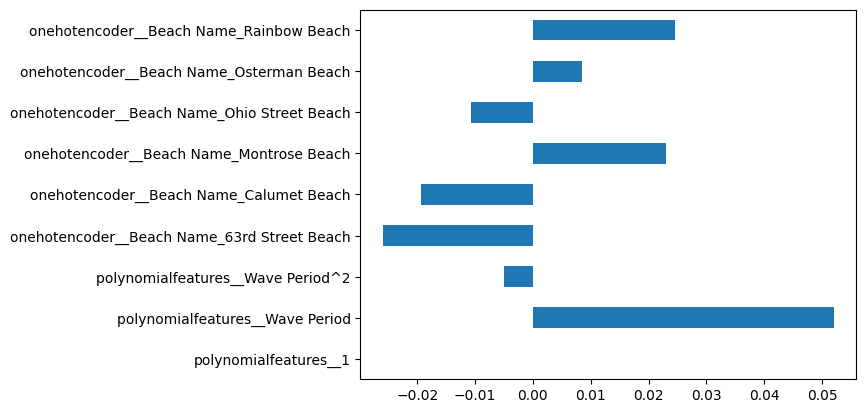

In [56]:
s = pd.Series(m4["lr"].coef_, index=m4["transformers"].get_feature_names_out())
s.plot.barh()